In [1]:
!pip install evaluate requests ultralytics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 19.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0mqp0a7m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0mqp0a7m
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-05-03 07:06:16--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.192.18.54, 54.192.18.50, 54.192.18.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.192.18.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   108MB/s    in 22s     

2024-05-03 07:06:38 (109 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]



In [79]:
import os
import shutil
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import torch
import numpy as np
import pandas as pd
import random

from transformers import (
    AutoImageProcessor, AutoModelForImageClassification,
    AutoModelForObjectDetection, ImageClassificationPipeline,
    TrainingArguments, Trainer, pipeline
)

from transformers.image_utils import load_image
import evaluate
from datasets import load_dataset

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from io import BytesIO
from PIL import Image, ImageDraw
import cv2

from requests import get
from huggingface_hub import hf_hub_download

import ultralytics
from ultralytics import YOLO
from supervision import Detections

from datasets import Dataset, DatasetDict, load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Aug Data Reading

In [ ]:
# Словарь для преобразования числовых меток в строковые
label_mapping = {
    0: "neutral",
    1: "microsleep",
    2: "yawning",
}

In [ ]:
# Directory containing the images
directory = '/kaggle/input/aminfins/gaz_aug_zip/neutral_aug/'

# Create a list to store PIL images
neutral_images_new = []

# Iterate over all files in the directory
for filename in os.listdir(directory):

        # Construct the full path to the image file
        file_path = os.path.join(directory, filename)
        # Open the image file as a PIL image and append it to the list
        pil_image = Image.open(file_path)
        neutral_images_new.append(pil_image)

In [ ]:
# Directory containing the images
directory = '/kaggle/input/aminfins/gaz_aug_zip/microsleep_aug/'

# Create a list to store PIL images
microsleep_images_new = []

# Iterate over all files in the directory
for filename in os.listdir(directory):

        # Construct the full path to the image file
        file_path = os.path.join(directory, filename)
        # Open the image file as a PIL image and append it to the list
        pil_image = Image.open(file_path)
        microsleep_images_new.append(pil_image)

In [ ]:
# Directory containing the images
directory = '/kaggle/input/aminfins/gaz_aug_zip/yawning_aug/'

# Create a list to store PIL images
yawning_images_new = []

# Iterate over all files in the directory
for filename in os.listdir(directory):

        # Construct the full path to the image file
        file_path = os.path.join(directory, filename)
        # Open the image file as a PIL image and append it to the list
        pil_image = Image.open(file_path)
        yawning_images_new.append(pil_image)

In [ ]:
neutral_labels = [0] * len(neutral_images_new)
microsleep_labels = [1] * len(microsleep_images_new)
yawning_labels = [2] * len(yawning_images_new)

In [ ]:
all_images = neutral_images_new + microsleep_images_new + yawning_images_new
all_labels = neutral_labels + microsleep_labels + yawning_labels

In [ ]:
# Разделение данных на тренировочную и тестовую выборку
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.15, random_state=0)

# Создание объектов Dataset для тренировочной и тестовой выборок
train_dataset = Dataset.from_dict({"image": train_images, "label": train_labels})
test_dataset = Dataset.from_dict({"image": test_images, "label": test_labels})

# Создание объекта DatasetDict
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Вывод информации о DatasetDict
print(dataset)

In [ ]:
metric = load_metric("accuracy")

In [ ]:
example = dataset["train"][122]
print(label_mapping[example['label']])
example['image']

In [ ]:
id2label = label_mapping
label2id = {v: k for k, v in id2label.items()}

model_checkpoint = "microsoft/resnet-50"
batch_size = 8
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
train_ds = dataset['train']
val_ds = dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

# Train

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
args = TrainingArguments(
    "train_image_kabyte",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=10,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Test

In [ ]:
pred_labels = []
classifier = pipeline("image-classification", model='/kaggle/working/train_image_kabyte/checkpoint-3110')

for image in test_images:
    pred_label = label2id[classifier(image)[0]['label']]
    pred_labels.append(pred_label)

In [ ]:
metrics = pd.DataFrame({
    "Test": [
        accuracy_score(pred_labels, test_labels),
        precision_score(pred_labels, test_labels, average='macro'),
        recall_score(pred_labels, test_labels, average='macro'),
        f1_score(pred_labels, test_labels, average='macro'),
    ],
}, index = ["Accuracy", "Precision", "Recall", "F1"])

metrics

5 epochs
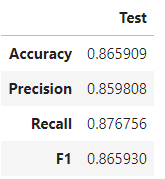


10 epochs
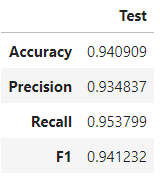

In [ ]:
classifier = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-3110')

In [ ]:
url = 'https://www.shutterstock.com/image-photo/young-handsome-man-waking-morning-260nw-254734102.jpg'
image = Image.open(get(url, stream=True).raw)
image

In [ ]:
classifier1500 = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-1500')
classifier3110 = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-3110')

print(f'1500: {classifier1500(image)[0]}')
print(f'3110: {classifier3110(image)[0]}')

# Classifier with Face Detection

In [204]:
def clf_face_3110(url):
    # download model
    model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

    # load model
    model = YOLO(model_path)

    # label mapping
    label2text = {
        "neutral": 'бодрствует',
        "microsleep": 'спит',
        "yawning": 'зевает',
    }

    # inference
    output = model(Image.open(get(url, stream=True).raw))
    results = Detections.from_ultralytics(output[0])
    
    # Create a list to store cropped images
    cropped_images = []

    if results.xyxy.size > 0:
    
        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the image
        image = Image.open(get(url, stream=True).raw)
        ax.imshow(image)

        # Draw boxes for detected faces with padding
        for i, xyxy in enumerate(results.xyxy):
            x_min, y_min, x_max, y_max = xyxy
            padding = (y_max - y_min)*0.5
            # Add padding
            x_min -= padding
            y_min -= padding
            x_max += padding
            y_max += 2.5*padding
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Annotate with numbers and background
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
            ax.text(x_min, y_min, str(i+1), color='black', fontsize=12, ha='left', va='top', bbox=bbox_props)

            # Crop the image based on the bounding box
            cropped_img = image.crop((x_min, y_min, x_max, y_max))
            cropped_images.append(cropped_img)
        plt.show()

        # Classifier model
        classifier = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-3110')

        # Classify each cropped image
        for i, cropped_img in enumerate(cropped_images):
            print(f"Человек на картинке {i+1} с вероятностью {int(100 * round(classifier(cropped_img)[0]['score'], 2))}% {label2text[classifier(cropped_img)[0]['label']]}.") 
    
    else:
        print("Людей не фото не обнаружено.")

# Classifier with Person Detection

In [234]:
def clf_person_3110(url):

    # Load image
    image = Image.open(get(url, stream=True).raw)

    # Load processor and model
    processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

    # Process inputs
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Post-process object detection results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.6)[0]

    # label mapping
    label2text = {
        "neutral": 'бодрствует',
        "microsleep": 'спит',
        "yawning": 'зевает',
    }
    
    filtered_detections = [(score, label, box) for score, label, box in zip(results["scores"], results["labels"], results["boxes"]) if model.config.id2label[label.item()] == 'person' and score.item() > 0.88]

    if filtered_detections:
        
        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(image)

        # Store cropped images of persons
        cropped_images = []    
    
        # Iterate over the results, only for persons with high confidence
        for i, (score, label, box) in enumerate(filtered_detections):
            box = [round(coord, 2) for coord in box.tolist()] 
            # Draw bounding box on the image
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Annotate with numbers and background
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
            ax.text(box[0], box[1], str(i+1), color='black', fontsize=12, ha='left', va='top', bbox=bbox_props)

            # Crop the person from the original image
            person_img = image.crop((box[0], box[1], box[2], box[3]))  # Corrected cropping coordinates
            cropped_images.append(person_img)

        # Show the image with bounding boxes
        plt.axis('off')
        plt.show()
        

        # Classifier model
        classifier = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-3110')

        # Classify each cropped image
        for i, cropped_img in enumerate(cropped_images):
            # Classify the cropped image
            prediction = classifier(cropped_img)[0]
            # Get the label and score
            label_text = label2text[prediction['label']]
            score = int(100 * round(prediction['score'], 2))
            # Print the classification result
            print(f"Человек на картинке {i+1} с вероятностью {score}% {label_text}.")
    
    else:
        print("Людей не фото не обнаружено.")

In [240]:
urls = [
'https://as1.ftcdn.net/v2/jpg/00/72/21/90/1000_F_72219046_WmTgchiYSNEUWrGggispWfYdT2xLDhbZ.jpg',
'https://t3.ftcdn.net/jpg/02/51/45/80/240_F_251458070_cbrSmk8NqXWJpxEzxWbLpIJE8kCnFL5i.jpg',
'https://as1.ftcdn.net/v2/jpg/01/13/52/06/1000_F_113520656_sztSZqJPTU2ULEwXZGJ2Dw5zh0B3lueU.jpg',
'https://as1.ftcdn.net/v2/jpg/03/32/93/82/1000_F_332938226_oyspt8Cdk0F4C9wcOPgdq5oN08z62zqg.jpg',
'https://as2.ftcdn.net/v2/jpg/03/32/43/51/1000_F_332435143_xvOYyIrMCKySKnwAZxN29BSNV63ROrHB.jpg',
'https://as1.ftcdn.net/v2/jpg/06/91/69/06/1000_F_691690648_lgkgUeLpBdKwjzs3L7SgvQgqjit4Ve1j.jpg',
'https://as2.ftcdn.net/v2/jpg/06/91/69/11/1000_F_691691195_6ZdSJKRFy3IPyuvXeTJ65OAcc76LSX76.jpg',
'https://as2.ftcdn.net/v2/jpg/03/25/85/63/1000_F_325856361_gJqkgVbfVDZyV0NL5vmPFNTovwv7rtJN.jpg',
'https://as2.ftcdn.net/v2/jpg/02/74/41/35/1000_F_274413590_2XDO1TnFvjNmq5zuGxKbbyHbFqFPQjoI.jpg',
'https://as1.ftcdn.net/v2/jpg/07/80/42/00/1000_F_780420090_KqPbLs5bQt5kGlpyVd3emVV8v3Iq766c.jpg',
'https://as2.ftcdn.net/v2/jpg/06/81/01/79/1000_F_681017952_uAyml8YJ7rr4ztyr6b2OGoGo9Ye67S4F.jpg',
'https://as2.ftcdn.net/v2/jpg/06/80/85/63/1000_F_680856330_ZJ4qhDG2R7E5FC79Xwego7nv0nI9guPm.jpg',
'https://as2.ftcdn.net/v2/jpg/05/69/86/83/1000_F_569868386_6MpAX89OkxOCRI7vyP45r84EncqSRjIn.jpg',
'https://as1.ftcdn.net/v2/jpg/03/86/17/72/1000_F_386177263_0lBUHkxb5D6pr5a0vsr4E58u6wdCkcPb.jpg',
'https://as2.ftcdn.net/v2/jpg/02/84/52/99/1000_F_284529974_4gQdVf3pGjhWEdS5FmlaRdmfsXcwaa3U.jpg',
'https://as1.ftcdn.net/v2/jpg/05/17/96/20/1000_F_517962042_PssY3rZpOEpC9LN0kiF3t5m3vdn18LXd.jpg'
]

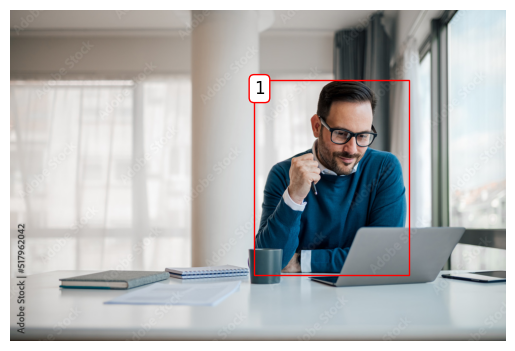

Человек на картинке 1 с вероятностью 98% бодрствует.
CPU times: user 4.5 s, sys: 176 ms, total: 4.68 s
Wall time: 3.32 s


In [241]:
%%time
clf_person_3110(urls[-1])

### Заметки:
1. если модель видит в кадре руку рядом с лицом, она с большой вероятностью предскажет зевание
2. если у человека закрыты глаза, например, он моргнул, прищурился или опустил их, модель с большой вероятностью предскажет сон
3. если картинка размазана, она с большой вероятностью предскажет сон, так как на лице будет больше темных пикселей
4. Использование полигонов вместо прямоугольных рамок возможно улучшило бы модель.
5. Если на картинке всего один человек, модель справляется очень хорошо
6. Рамки могут перекрываться, что может запутать модель
7. Более разнообразные данные (люди с книгами, кружками, ноутбуками и т.п.) также улучшили бы качество модели
8. Модель с лицами работает быстрее, чем модель с человеком полностью, и уж тем более намного быстрее чем SAM.

# Image Segmentation

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# Load image from URL
url = 'https://as1.ftcdn.net/v2/jpg/00/72/21/90/1000_F_72219046_WmTgchiYSNEUWrGggispWfYdT2xLDhbZ.jpg'
image = Image.open(get(url, stream=True).raw)
image_array = np.array(image)
image

In [ ]:
sam_result = mask_generator.generate(image_array)

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_array.copy(), detections=detections)

if image_array.shape[-1] == 3:
    image_rgb = image_array
else:
    image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

# Convert the image to a PIL Image object
image_pil = Image.fromarray(image_rgb)

# Now you can visualize the results
sv.plot_images_grid(
    images=[image_pil, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(10, 10),
    size=(16, 16)
)

In [ ]:
# Filter detections to keep only those related to humans
human_detections = [detection for detection in detections if detection.label == 'person']

# If there are no detections related to humans, handle the case accordingly
if not human_detections:
    print("No human detections found.")
    # You can choose to exit the code or perform some other action
else:
    # Extract mask data for human detections
    human_mask_data = sam_result.masks_for_detections(human_detections)

    # Annotate the image with human masks
    human_annotated_image = mask_annotator.annotate(scene=image_array.copy(), detections=human_detections, mask_data=human_mask_data)

    # Convert the image to a PIL Image object
    if image_array.shape[-1] == 3:
        image_rgb = image_array
    else:
        image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Visualize the results
    sv.plot_images_grid(
        images=[image_pil, human_annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image (humans only)']
    )


# Another Try with Boxes

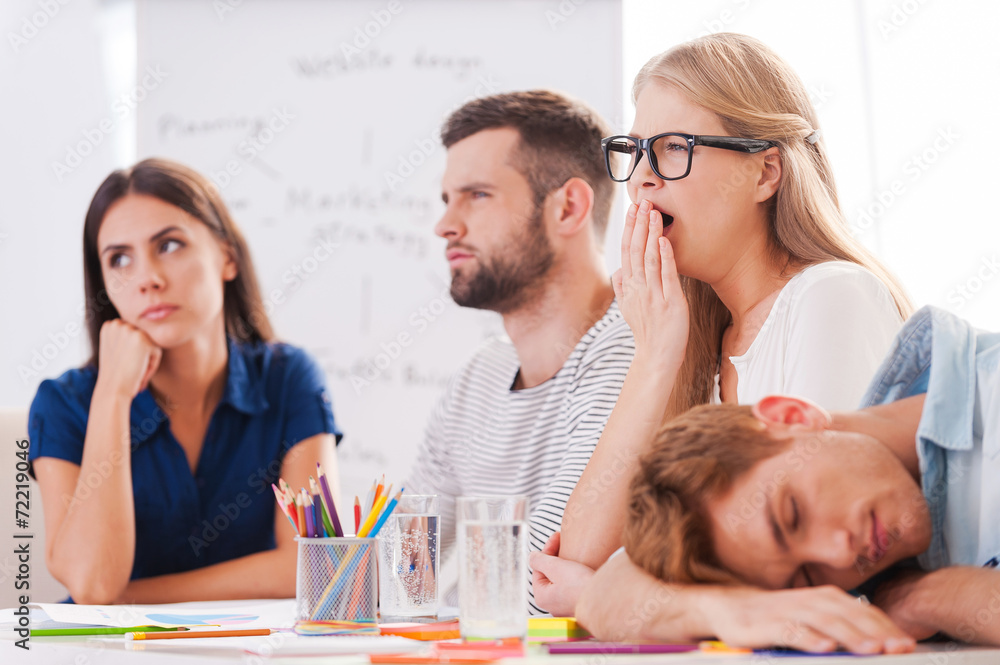

In [6]:
url = 'https://as1.ftcdn.net/v2/jpg/00/72/21/90/1000_F_72219046_WmTgchiYSNEUWrGggispWfYdT2xLDhbZ.jpg'
image = Image.open(get(url, stream=True).raw)
image

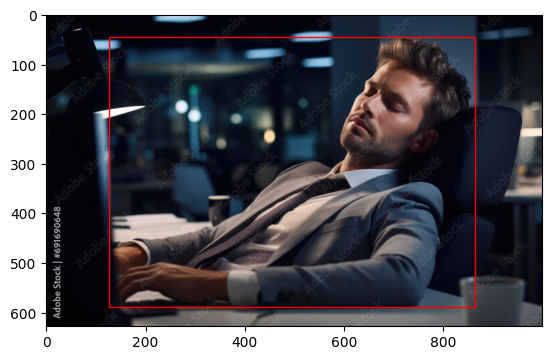

In [68]:
# Load image from URL
url = 'https://as1.ftcdn.net/v2/jpg/06/91/69/06/1000_F_691690648_lgkgUeLpBdKwjzs3L7SgvQgqjit4Ve1j.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Load processor and model
processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Process inputs
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Post-process object detection results
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.4)[0]

# Store cropped images of persons
person_images = []
boxes = []

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Draw boxes only for persons with high confidence
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    label_name = model.config.id2label[label.item()]
    if label_name == 'person' and score.item() > 0.88:  # Adjust the threshold here
        color = (1, 0, 0)  # Red color
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Crop the person from the original image
        person_img = image.crop((box[0], box[1], box[2], box[3]))  # Corrected cropping coordinates
        person_images.append(person_img)
        boxes.append(box)
        
image_np = np.array(image)

# Show the image with bounding boxes
plt.show()

In [65]:
boxes[0]

[125.72, 44.25, 864.2, 589.51]

In [49]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=sam_checkpoint).to(device=DEVICE)
predictor = SamPredictor(sam)

In [69]:
predictor.set_image(image_np)

In [70]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

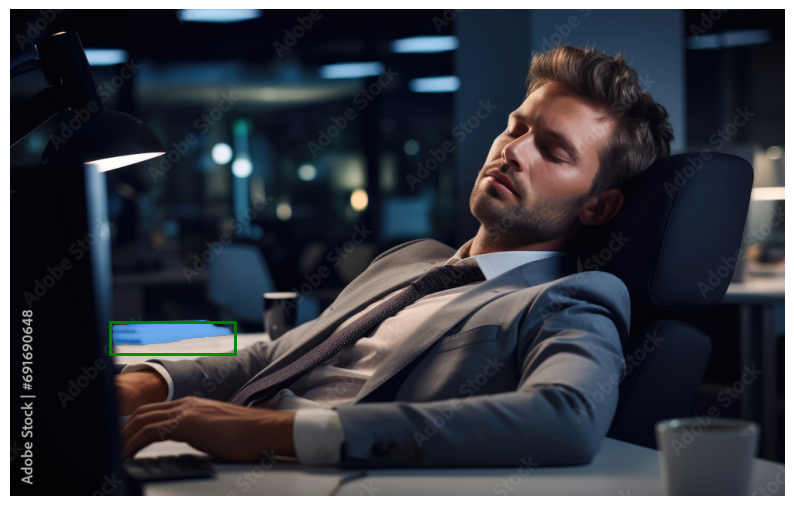

In [71]:
input_box = np.array(box)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

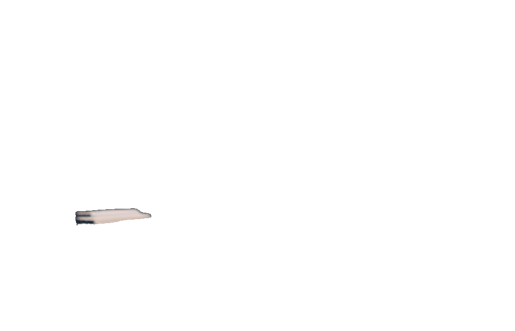

In [72]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

# Maybe YOLO

In [96]:
# URL of the image
url = 'https://as1.ftcdn.net/v2/jpg/00/72/21/90/1000_F_72219046_WmTgchiYSNEUWrGggispWfYdT2xLDhbZ.jpg'
# Download the image from the URL
response = requests.get(url)

# Save the image to a local file
with open('temp_image.jpg', 'wb') as f:
    f.write(response.content)

In [97]:
model = YOLO('/content/yolov8n.pt')
results = model.predict(source='temp_image.jpg', conf=0.25)


image 1/1 /kaggle/working/temp_image.jpg: 448x640 6 persons, 2 cups, 62.2ms
Speed: 2.1ms preprocess, 62.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


In [99]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[[28.7656307220459, 155.81546020507812, 347.1243896484375, 607.3956298828125],
 [407.7901916503906, 88.9902114868164, 687.7156982421875, 564.1715087890625],
 [535.903564453125, 32.56683349609375, 917.0020751953125, 586.358642578125],
 [454.2904052734375, 495.436279296875, 530.7802124023438, 644.4620361328125],
 [535.5042724609375, 402.17401123046875, 993.0665893554688, 652.5689086914062],
 [293.7384033203125, 533.0150756835938, 383.44012451171875, 625.4375610351562],
 [757.8594970703125, 302.88958740234375, 999.70751953125, 643.4176635742188],
 [529.153564453125, 142.80409240722656, 946.7809448242188, 651.0447998046875]]

In [77]:
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [80]:
image = cv2.cvtColor(cv2.imread('temp_image.jpg'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [81]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

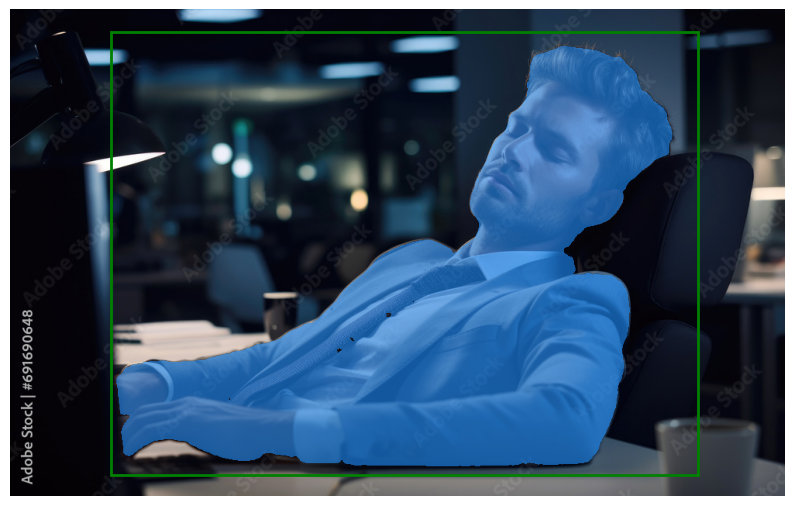

In [82]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

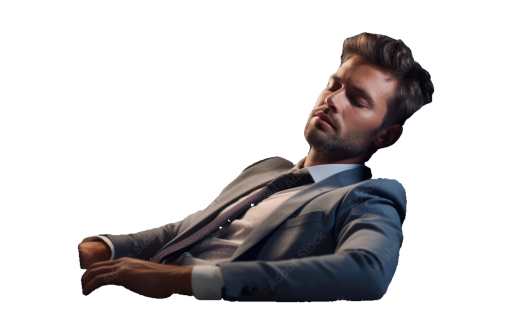

In [83]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [94]:
classifier3110 = pipeline("image-classification", model='/kaggle/input/aminfins/checkpoint-3110')
image_pil = Image.fromarray(new_image.astype(np.uint8))

classifier3110(image_pil)

[{'label': 'microsleep', 'score': 0.5729373693466187},
 {'label': 'neutral', 'score': 0.3772326707839966},
 {'label': 'yawning', 'score': 0.04983000084757805}]

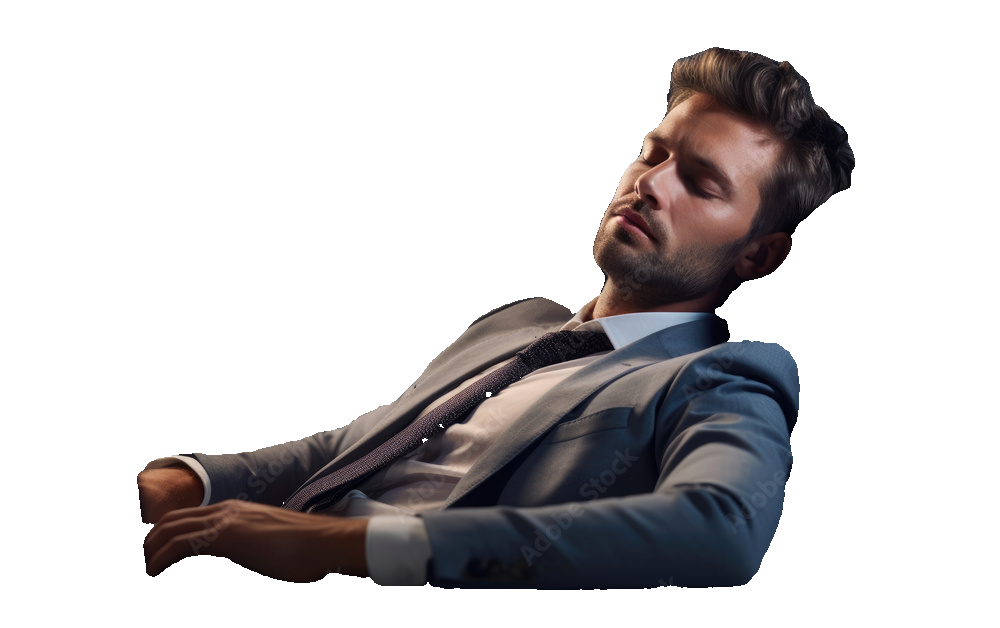

In [95]:
image_pil